## 0. Import Libraries

In [2]:
from datetime import datetime, timedelta
from glob import glob

import numpy as np
import pandas as pd
import pyproj
import rioxarray
import salem
import xarray as xr
from shapely.geometry import mapping

import cartopy
import matplotlib.pyplot as plt
import proplot
from matplotlib.colors import BoundaryNorm, ListedColormap
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from dea_tools.spatial import xr_vectorize, xr_rasterize
import metpy.calc as mpcalc
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy, vertcross
from netCDF4 import Dataset
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)
from metpy.units import units
from scipy.constants import g

import warnings
warnings.filterwarnings('ignore')

## 1. Open Data

In [3]:
def open_data(run_data, variable):
    """
    Opens relevant xarray wrf data
    """
    
    # data path
    data_path = glob(fr'{general_path}/*{run_data}**{variable}*')

    # open data
    dt = xr.open_mfdataset(data_path,
                           concat_dim='ens')

    # instead of 201 grid we want 200 grid in each direction
    dt_clip = dt.isel(south_north=slice(0,200),
                 west_east=slice(0,200))
    
    # change var name
    if variable == 'spehum':
        dt_clip = dt_clip.rename({'__xarray_dataarray_variable__':variable})
    
    return dt_clip

def modify_ens_names(dt):
    
    dt['ens'] = ['LIN_nourban', 'LIN_urban',
               'THOMPSON_nourban', 'THOMPSON_urban',
               'WSM6_nourban', 'WSM6_urban']
    
    return dt

In [4]:
general_path = 'data'

# ensemble members
micro_options = [
    'LIN',
    'THOMPSON',
    'WSM6'
]

luse_options = [
    'urban',
    'nourban'
]

### 1.1 ERA5

In [5]:
run_data = 'era5'
variables = ['spehum', 'ua', 'va', 'PRESSURE']

dt_era5 = {}
for v in variables:
    
    dt = open_data(run_data, v)
    dt = modify_ens_names(dt)
    dt_era5[v] = dt
    
# assign units
dt_era5['spehum'] = dt_era5['spehum'] * units('kg/kg')
dt_era5['ua'] = dt_era5['ua'] * units('m/s')
dt_era5['va'] = dt_era5['va'] * units('m/s')
dt_era5['PRESSURE'] = dt_era5['PRESSURE'] * units('hPa') # hpa 

### 1.2 GFS

In [6]:
run_data = 'gfs'

dt_gfs = {}
for v in variables:
    
    dt = open_data(run_data, v)
    dt = modify_ens_names(dt)
    dt_gfs[v] = dt
    
# assign units
dt_gfs['spehum'] = dt_gfs['spehum'] * units('kg/kg')
dt_gfs['ua'] = dt_gfs['ua'] * units('m/s')
dt_gfs['va'] = dt_gfs['va'] * units('m/s')
dt_gfs['PRESSURE'] = dt_gfs['PRESSURE'] * units('hPa') # hpa 

## 2. Calculate IVP

In [7]:
def create_levels(dt, press, levels):
    
    dts = []
    for l in levels:
        dt_lev = interplevel(dt, press, l)
        dts.append(dt_lev)
    return xr.concat(dts, dim='level')

In [8]:
def calculate_ivt(dt_qu, dt_qv, levels):
    """
    long version of dt.integrate(coord = 'level')
    """
    
    ivtx = 0
    ivty = 0

    for i in range(len(levels)-1):

        delta = (levels[i+1]-levels[i]) * 1e3 * units('kg*m**-1*s**-2') # hPa to Pa
        qu_delta = ((dt_qu.sel(level=levels[i]) + dt_qu.sel(level=levels[i+1])) / 2) * delta
        qv_delta = ((dt_qv.sel(level=levels[i]) + dt_qv.sel(level=levels[i+1])) / 2) * delta

        ivtx += qu_delta
        ivty += qv_delta   
        
    return (-1/g*units('s**2/m'))*ivtx, (-1/g*units('s**2/m'))*ivty

In [9]:
# general parameters
ens_members = ['LIN_nourban', 'LIN_urban',
               'THOMPSON_nourban', 'THOMPSON_urban',
               'WSM6_nourban', 'WSM6_urban']
pr_var = 'PRESSURE'
levels = [900, 875, 850, 825, 800, 775, 750, 725, 700]

### 2.1 ERA5

In [10]:
dt_var_era5 = {}

for v in ['spehum', 'ua', 'va']:
    
    dt_ens = []
    for ens in ens_members:
        
        dt_ = dt_era5[v][v].sel(ens = ens)
        press_ = dt_era5[pr_var][pr_var].sel(ens = ens)
        dt_lev = create_levels(dt_, press_, levels)
        dt_ens.append(dt_lev)
        
    dt_var_era5[v] = xr.concat(dt_ens, dim='ens')

In [11]:
qu = (dt_var_era5['spehum']*units('kg/kg') * dt_var_era5['ua'] * units('m/s'))
qv = (dt_var_era5['spehum']*units('kg/kg') * dt_var_era5['va'] * units('m/s'))

ivtx_era5, ivty_era5 = calculate_ivt(qu, qv, levels) # unit is kg/ms
ivt_era5 = np.sqrt(ivtx_era5**2 + ivty_era5**2)

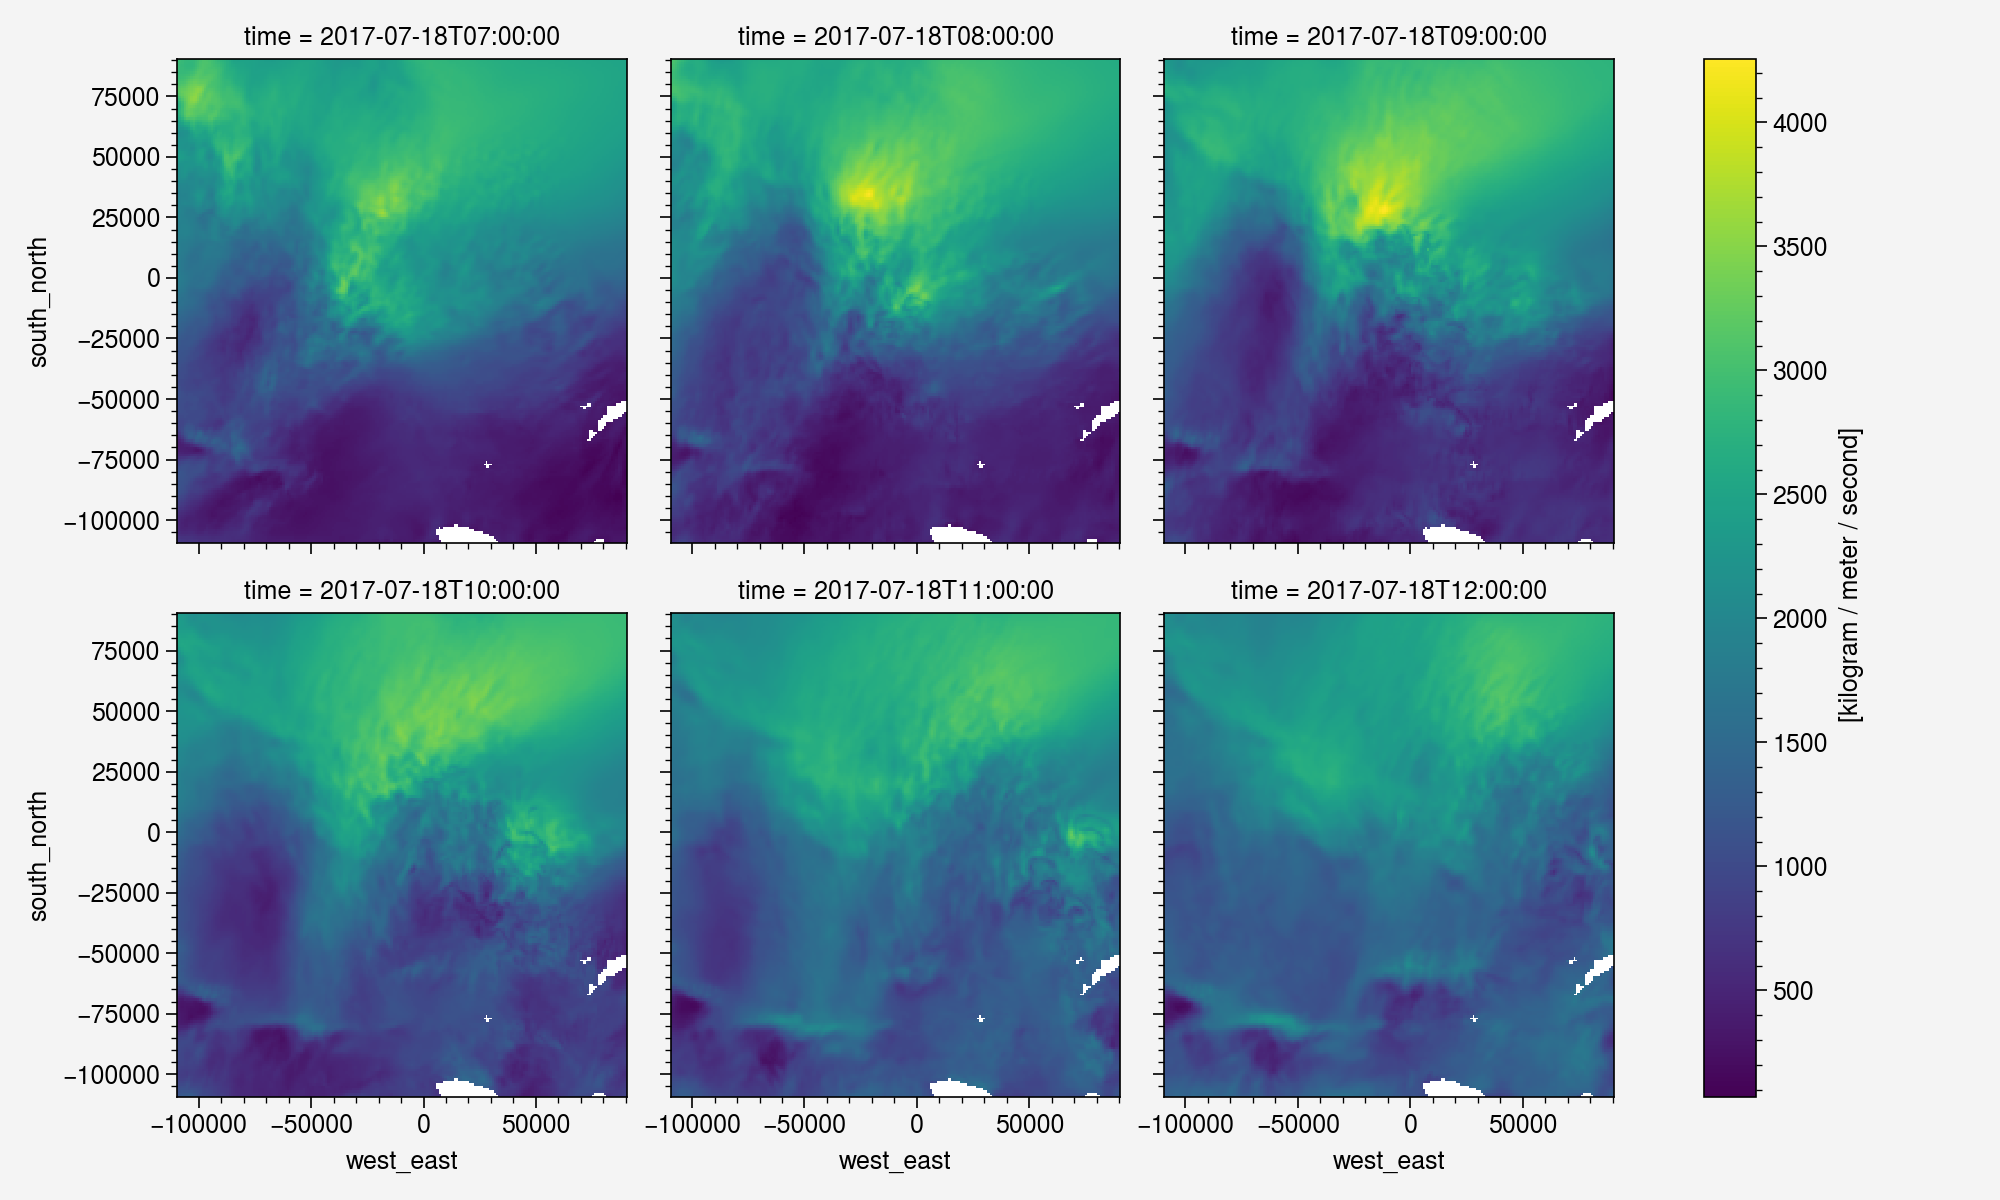

In [12]:
ivt_era5.mean(dim='ens').plot(col='time', col_wrap=3)

### 2.2 GFS

In [13]:
dt_var_gfs = {}

for v in ['spehum', 'ua', 'va']:
    
    dt_ens = []
    for ens in ens_members:
        
        dt_ = dt_gfs[v][v].sel(ens = ens)
        press_ = dt_era5[pr_var][pr_var].sel(ens = ens)
        dt_lev = create_levels(dt_, press_, levels)
        dt_ens.append(dt_lev)
        
    dt_var_gfs[v] = xr.concat(dt_ens, dim='ens')

In [14]:
qu = (dt_var_gfs['spehum']*units('kg/kg') * dt_var_gfs['ua'] * units('m/s'))
qv = (dt_var_gfs['spehum']*units('kg/kg') * dt_var_gfs['va'] * units('m/s'))

ivtx_gfs, ivty_gfs = calculate_ivt(qu, qv, levels) # unit is kg/ms
ivt_gfs = np.sqrt(ivtx_gfs**2 + ivty_gfs**2)

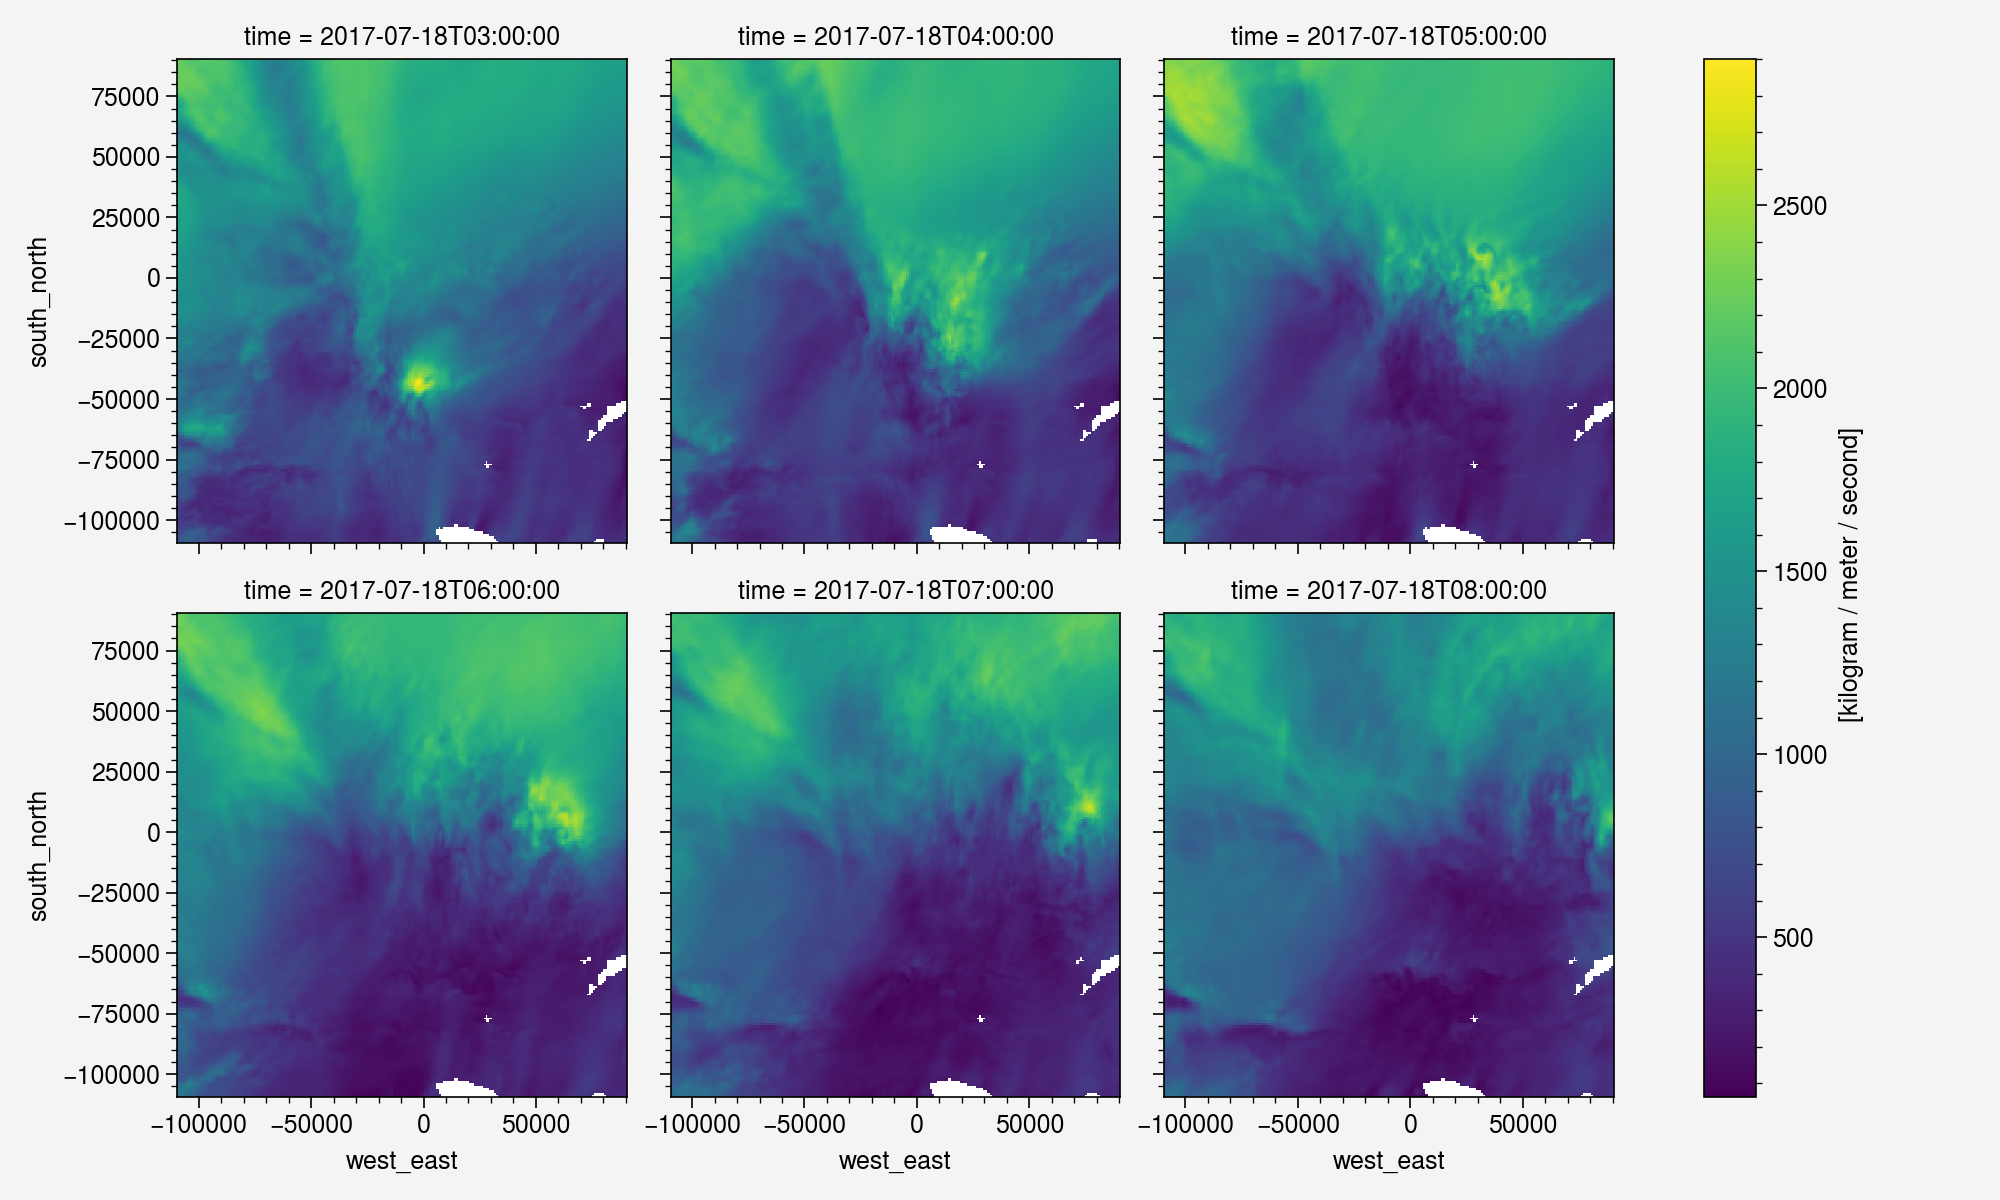

In [15]:
ivt_gfs.mean(dim='ens').plot(col='time', col_wrap=3)

## 3 Define Members

In [16]:
# ensemble member list
ensemble_members = list(dt.ens.values)

# urban and nourban members
urban_members = [ens for ens in ensemble_members if not 'nourban' in ens ]
nourban_members = [ens for ens in ensemble_members if 'nourban' in ens ]

### 3.1 Ensemble Mean For Urban and Nourban

#### 3.1.1 ERA5

In [17]:
# ivtx
ivtx_era5_urban = ivtx_era5.sel(ens=urban_members).mean(dim='ens')
ivtx_era5_nourban = ivtx_era5.sel(ens=nourban_members).mean(dim='ens')

# ivty
ivty_era5_urban = ivty_era5.sel(ens=urban_members).mean(dim='ens')
ivty_era5_nourban = ivty_era5.sel(ens=nourban_members).mean(dim='ens')

# ivt
ivt_era5_urban = ivt_era5.sel(ens=urban_members).mean(dim='ens')
ivt_era5_nourban = ivt_era5.sel(ens=nourban_members).mean(dim='ens')

#### 3.1.2 GFS

In [18]:
# ivtx
ivtx_gfs_urban = ivtx_gfs.sel(ens=urban_members).mean(dim='ens')
ivtx_gfs_nourban = ivtx_gfs.sel(ens=nourban_members).mean(dim='ens')

# ivty
ivty_gfs_urban = ivty_gfs.sel(ens=urban_members).mean(dim='ens')
ivty_gfs_nourban = ivty_gfs.sel(ens=nourban_members).mean(dim='ens')

# ivt
ivt_gfs_urban = ivt_gfs.sel(ens=urban_members).mean(dim='ens')
ivt_gfs_nourban = ivt_gfs.sel(ens=nourban_members).mean(dim='ens')

## 4. Visualization

### 4.1 Open Land Use Datasets

In [19]:
luse_var = 'LU_INDEX'
urban_luse_border = xr.open_dataset(fr'{general_path}/wrfout_d03_LU_INDEX_urban.nc')[luse_var]
urban_luse_border = urban_luse_border.where(urban_luse_border==1, 0).isel(west_east = slice(35, 162),
                                                                               south_north = slice(57, 157))

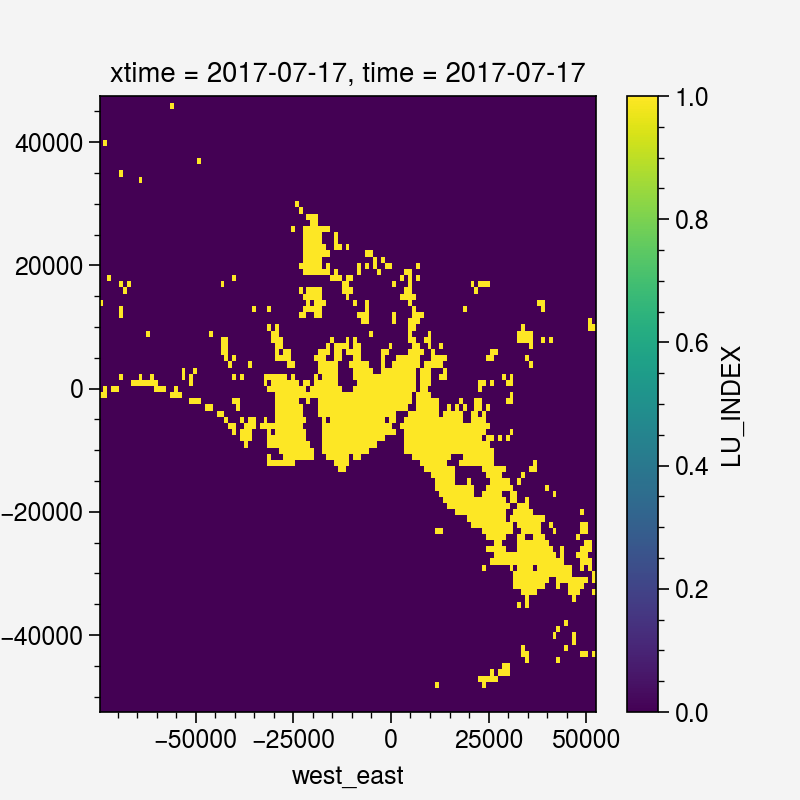

In [20]:
urban_luse_border.plot()

### 4.2 Parameters

In [21]:
# cmap for total urban and nourban hourly IVT
nws_precip_colors_total = [
    "#ffffff",
    "#fff688",
    "#ffe22d",
    "#ffc70f", 
    "#ffac00", 
    "#ff8d00", 
    "#ff6e00", 
    "#ff4200", 
    "#d21313",
    "#a1a1a1",
    "#bfbfbf",
    "#d3d3d3",
]
cmap = ListedColormap(nws_precip_colors_total)

In [22]:
# Parameters to change (plot) -------------------
# projection
# assign projection and dim info
dt_proj = dt['PRESSURE'].copy(deep=True)
dt_proj = dt_proj.rio.write_crs(dt_proj.attrs['pyproj_srs'])
dt_proj = dt_proj.rio.set_spatial_dims(x_dim='west_east',
                             y_dim='south_north')
proj = dt_proj.rio.crs.to_dict()
globe = cartopy.crs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
lcc = cartopy.crs.LambertConformal(globe=globe, # important!
                            central_longitude=proj['lon_0'], 
                            central_latitude=proj['lat_0'],
                            standard_parallels=(proj['lat_1'], proj['lat_2']),
                            )

# fig features
fig_array = [[1, 2],
             [3, 4],
             [5, 6],
             [7, 8],
             [9,10],
             [11,12]
            ]
graphic_no = 12

# graphic vmin, vmax and norms
clevs_total = [0, 1000, 1200, 1400, 1600, 1800, 2000,
               2200, 2400, 3000, 3500, 4000, 4500]
norm = BoundaryNorm(clevs_total,
                    ncolors=cmap.N, 
                    clip=True)
ticks = [0, 2000, 4000]

### 4.3 Plot - ERA5

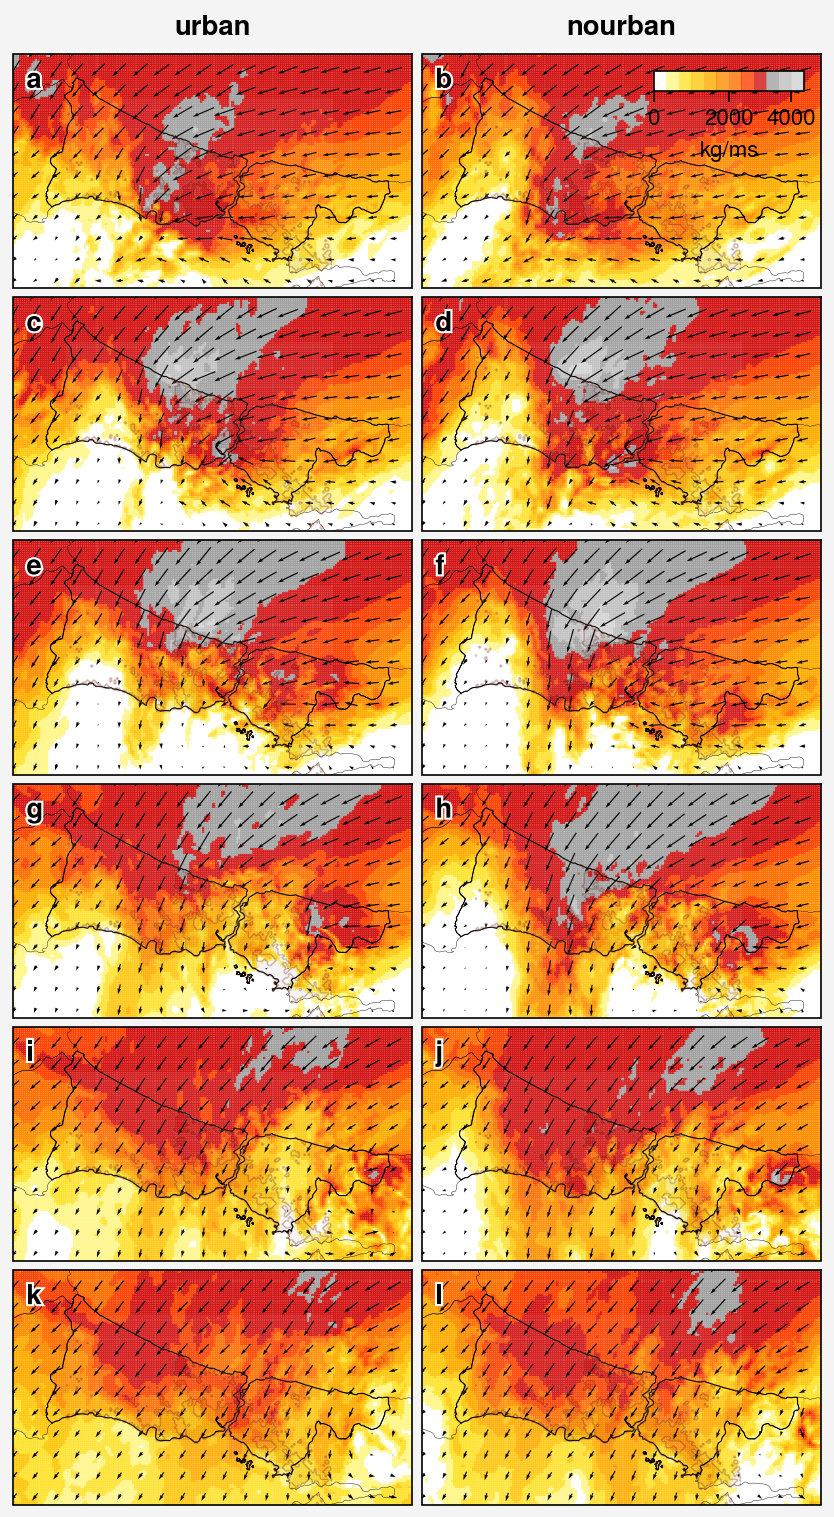

In [43]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=4,
                            axwidth=2,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.36,
                            wspace=0.36,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# istanbul limits
axs.format(lonlim=(27.69171143+0.10, 30.04271274),
           latlim=(40.08444595+0.60, 41.88309609-0.20),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(collabels=['urban', 'nourban'],
           #collabels=['08UTC', '09UTC', '10UTC', '11UTC']
           )

#proplot.rc['leftlabel.rotation'] = 'vertical'
proplot.rc.update({'leftlabel.rotation':'vertical'})

# add shapefiles
turkey_district_shape = r'data/shapefiles/istanbul_province_borders.shp'
shape_district_turkey = ShapelyFeature(Reader(turkey_district_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.4, zorder = 0.3)

turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
shape_province_turkey = ShapelyFeature(Reader(turkey_province_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.15, zorder = 0.4)


for i in range(graphic_no):
    axs[i].add_feature(shape_district_turkey)
    axs[i].add_feature(shape_province_turkey)  
    
dt_border = urban_luse_border

i_s = [0,0,1,1,2,2,3,3,4,4,5,5]
for i, t in zip(i_s, range(graphic_no)):
            
    if t in [0,2,4,6,8,10]:
        dt_luse = ivt_era5_urban
        dt_quiver_luse = [ivtx_era5_urban, ivty_era5_urban]

    else:
        dt_luse = ivt_era5_nourban
        dt_quiver_luse = [ivtx_era5_nourban, ivty_era5_nourban]
        
    mesh = axs[t].pcolormesh(dt_luse[i]['XLONG'], 
                            dt_luse[i]['XLAT'],
                            dt_luse[i], 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)
    
    quiver = axs[t].quiver(dt_quiver_luse[0][i][::10, ::10]['XLONG'], 
                        dt_quiver_luse[0][i][::10, ::10]['XLAT'],
                        dt_quiver_luse[0][i][::10, ::10],
                        dt_quiver_luse[1][i][::10, ::10],
                        zorder = 0.2,
                       pivot='middle', 
                            )
    
    contour = axs[t].contourf(dt_border['lon'], 
                            dt_border['lat'],
                            dt_border,
                            lw = 0.1,
                            alpha = 0.05,
                            
                            )

# colorbars
axs[1].colorbar(mesh,
                 label='kg/ms',
                 ticks = ticks,
                 loc='ur', length=6,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.8,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                )

#save figure
plt.savefig(r'pictures/era5_ENS_IVT_hourly.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)

### 4.3 Plot - GFS

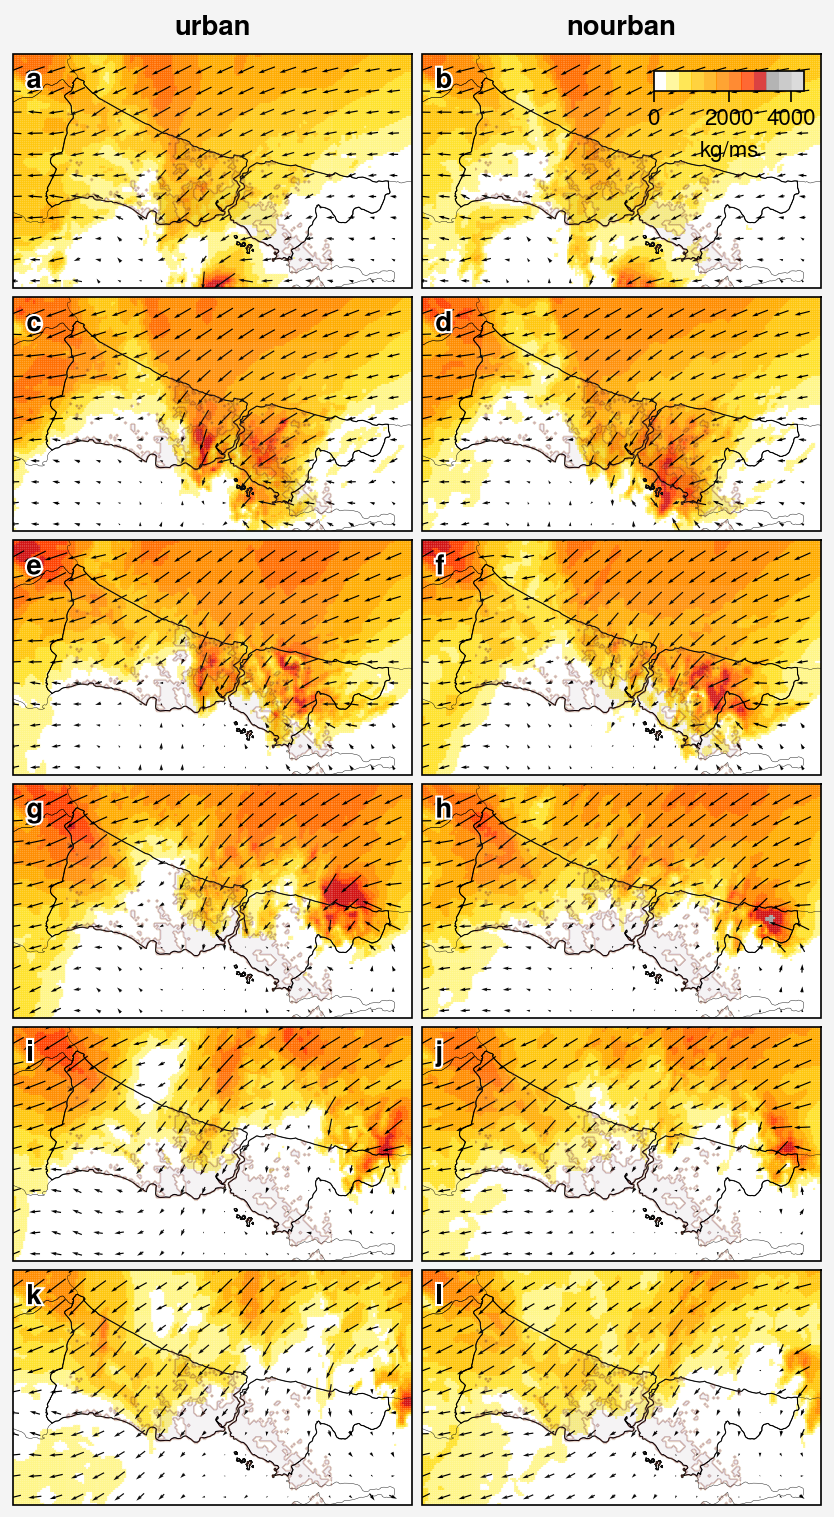

In [44]:
# Create Figure -------------------------
fig, axs = proplot.subplots(fig_array, 
                            aspect=4,
                            axwidth=2,
                            proj=lcc,
                            hratios=tuple(np.ones(len(fig_array), dtype=int)),
                            includepanels=True,
                            hspace=0.36,
                            wspace=0.36,
                            sharey=0)

# format whole figure
axs.format(abcloc='ul',
           abc=True,)

# istanbul limits
axs.format(lonlim=(27.69171143+0.10, 30.04271274),
           latlim=(40.08444595+0.60, 41.88309609-0.20),
           labels=False, 
           longrid=False, 
           latgrid = False)

axs.format(collabels=['urban', 'nourban'],
           #collabels=['08UTC', '09UTC', '10UTC', '11UTC']
           )

#proplot.rc['leftlabel.rotation'] = 'vertical'
proplot.rc.update({'leftlabel.rotation':'vertical'})

# add shapefiles
turkey_district_shape = r'data/shapefiles/istanbul_province_borders.shp'
shape_district_turkey = ShapelyFeature(Reader(turkey_district_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.4, zorder = 0.3)

turkey_province_shape = r'data/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp'
shape_province_turkey = ShapelyFeature(Reader(turkey_province_shape).geometries(),
                                             cartopy.crs.PlateCarree(), facecolor='none',
                                             edgecolor = 'black', linewidth = 0.15, zorder = 0.4)


for i in range(graphic_no):
    axs[i].add_feature(shape_district_turkey)
    axs[i].add_feature(shape_province_turkey)  
    
dt_border = urban_luse_border

i_s = [0,0,1,1,2,2,3,3,4,4,5,5]
for i, t in zip(i_s, range(graphic_no)):
            
    if t in [0,2,4,6,8,10]:
        dt_luse = ivt_gfs_urban
        dt_quiver_luse = [ivtx_gfs_urban, ivty_gfs_urban]

    else:
        dt_luse = ivt_gfs_nourban
        dt_quiver_luse = [ivtx_gfs_nourban, ivty_gfs_nourban]
        
    mesh = axs[t].pcolormesh(dt_luse[i]['XLONG'], 
                            dt_luse[i]['XLAT'],
                            dt_luse[i], 
                            cmap = cmap,
                            norm=norm,
                            zorder = 0.2,
                            alpha=0.8)
    
    quiver = axs[t].quiver(dt_quiver_luse[0][i][::10, ::10]['XLONG'], 
                        dt_quiver_luse[0][i][::10, ::10]['XLAT'],
                        dt_quiver_luse[0][i][::10, ::10],
                        dt_quiver_luse[1][i][::10, ::10],
                        zorder = 0.2,
                       pivot='middle', 
                            )
    
    contour = axs[t].contourf(dt_border['lon'], 
                            dt_border['lat'],
                            dt_border,
                            lw = 0.1,
                            alpha = 0.05,
                            
                            )

# colorbars
axs[1].colorbar(mesh,
                 label='kg/ms',
                 ticks = ticks,
                 loc='ur', length=6,  # length is em widths
                 tickminor=True, alpha=0.5,
                 width=0.8,
                 labelsize = 8,
                 ticklabelsize = 8,
                 frame=False,
                )

#save figure
plt.savefig(r'pictures/gfs_ENS_IVT_hourly.jpeg',
            bbox_inches='tight', optimize=True,
            progressive=True, dpi=1000)

## 5. Save IVT Data

In [24]:
# era5
ivt_era5_urban.to_netcdf(r'data/ivt_era5_postprocessed_urban.nc')
ivt_era5_nourban.to_netcdf(r'data/ivt_era5_postprocessed_nourban.nc')

# gfs
ivt_gfs_urban.to_netcdf(r'data/ivt_gfs_postprocessed_urban.nc')
ivt_gfs_nourban.to_netcdf(r'data/ivt_gfs_postprocessed_nourban.nc')